Epoch 1/50


/home/yangqi/anaconda3/envs/han_pytorch/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0532
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0046
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0036
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0033
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0028
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0026
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0025
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0021
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0019
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0017
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0017
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0014
Epoch 13/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0015
Epoch 14/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0014
Epoch 15/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0013
Epoch 16/50
67/

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.3181e-04
Test Loss: 0.00019492919091135263
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


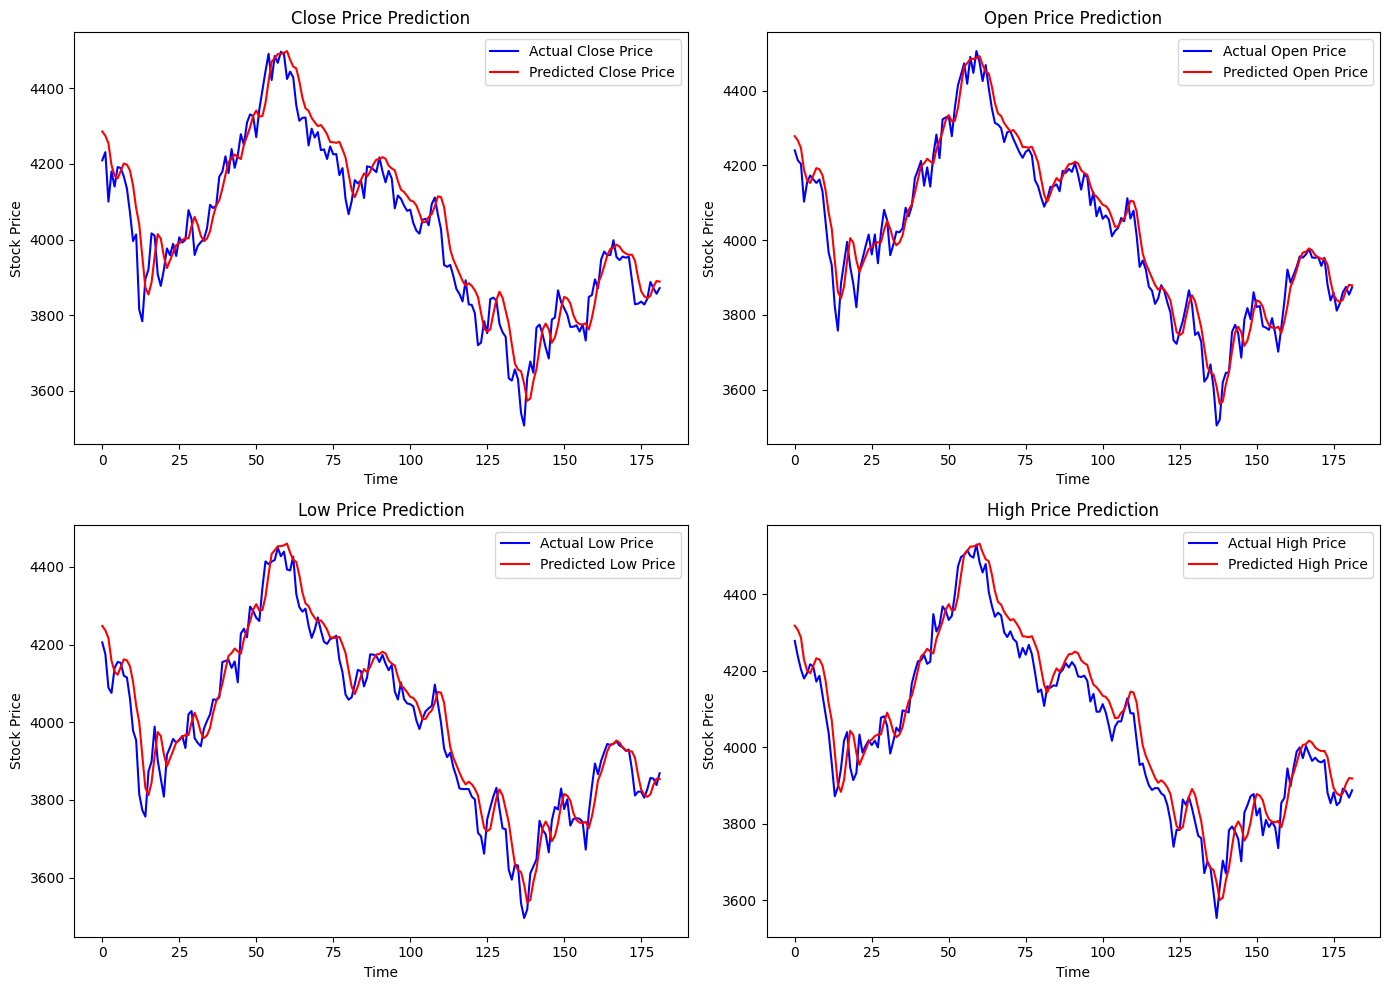

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import pickle

# Force TensorFlow to use CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Load the dataset
dataset_path = '/home/yangqi/anaconda3/envs/han_pytorch/csi300.csv'
csi300_data = pd.read_csv(dataset_path)

# Convert trade_date to datetime format
csi300_data['trade_date'] = pd.to_datetime(csi300_data['trade_date'], format='%Y%m%d')

# Sort the data by trade_date
csi300_data = csi300_data.sort_values(by='trade_date')

# Split the data: last year for testing, rest for training
test_data = csi300_data[csi300_data['trade_date'] >= '2022-01-01']
train_data = csi300_data[csi300_data['trade_date'] < '2022-01-01']

# Normalize the features
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['close', 'open', 'low', 'high']])
test_scaled = scaler.transform(test_data[['close', 'open', 'low', 'high']])

# Create sequences for LSTM
def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length]
        y = data[i+sequence_length]  # Predicting all prices
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 60
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, 4)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(4)  # Output layer with 4 neurons for 4 prices
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=50)

# Save the model and scaler
model.save('lstm_csi300_model.h5')
scaler_filename = 'scaler.pkl'
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(y_test)

# Plot the predictions
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(actual[:, 0], color='blue', label='Actual Close Price')
plt.plot(predictions[:, 0], color='red', label='Predicted Close Price')
plt.title('Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(actual[:, 1], color='blue', label='Actual Open Price')
plt.plot(predictions[:, 1], color='red', label='Predicted Open Price')
plt.title('Open Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(actual[:, 2], color='blue', label='Actual Low Price')
plt.plot(predictions[:, 2], color='red', label='Predicted Low Price')
plt.title('Low Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(actual[:, 3], color='blue', label='Actual High Price')
plt.plot(predictions[:, 3], color='red', label='Predicted High Price')
plt.title('High Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

plt.tight_layout()
plt.show()